# A Machine Learning Approach for Mean Velocity Prediction in Ungauged Basins
Codes to Reproduce the Results
Bidhyananda Yadav

- Use the same notebooks for feature selection and final ML algorithms  
- Tested on Both Windows Laptop and HPC

Change
To run for all features, change
    full_feature_flag = 1
To run a sparse model, change
    full_feature_flag = 0

In [2]:
# Set flag for full feature vs sparse feature
full_feature_flag = 1 #'1 = full, 0 = sparse

In [3]:
from matplotlib_scalebar.scalebar import ScaleBar

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import os, sys
import pickle
import numpy as np
import pandas as pd

import geopandas as gpd
import matplotlib.image as mpimg
import cartopy

# Using machine learning
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Modules for regression problem
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold #KFold is changed
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve

# Get some helper functions for timing, scalebar etc
from giuh_helpers import tic, toc, add_osgb_scalebar


In [6]:
# Set a random seed so that experiment can be replicated
randomseed = 28 #
np.random.seed(randomseed)
# For k-fold cross validation
cv = KFold(n_splits=10, shuffle=True,random_state=randomseed)

In [7]:
# Create Figure and Results folders to save outputs
fig_folder = 'journal_figs/velocity'
if full_feature_flag:
    print('Using all features')
    fig_folder = fig_folder + '/features'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

# To save models results (.pkl file)
results_folder = 'results'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

Using all features


# Load saved data from csv file

In [8]:
# Load Data from CSV file
df = pd.read_csv('data/velocity_regressors3.csv', index_col='site_no')
df.index = df.index.astype(str).str.zfill(8)

# Arrange columns in descending order of correlation with velocity; for easy visualization later
ind = df.corr().VELOCITY.sort_values(ascending=False).index
df = df[ind]

In [9]:
df.head()

,VELOCITY,SLOPE,ELEV,WSAREA,ARI,WTDEP,PRECIP,OW,SAND,HYDRCON,PERM,RCKDEP,IMP,DAM,RD,CLAY,TMIN,PET,TMEAN,TMAX
site_no,,,,,,,,,,,,,,,,,,,,
05430500,0.637188,0.011671,278.739277,8650.56660,0.860594,132.568403,877.251288,3.777475,33.146242,19.300608,9.603370,151.802872,3.248067,0.007278,2.139881,18.535015,2.630822,948.522547,8.086160,13.536474
05479000,0.649701,0.005556,366.632672,3387.70692,0.791043,103.064936,811.126550,0.779278,30.132510,19.390295,3.750390,152.400000,0.734868,0.003859,1.430399,26.051756,2.295433,965.844940,7.831898,13.363263
01531000,0.568716,0.089083,498.505749,6490.51494,0.908002,95.492186,925.138690,0.640073,23.588311,0.133481,4.951756,124.809793,0.853518,0.009543,1.771990,17.265181,1.681486,947.235500,7.638515,13.590622
01439500,0.569554,0.045742,398.967204,303.02883,1.182296,82.674786,1231.870327,2.193357,33.272308,0.146977,4.365513,143.182715,0.365900,0.035902,1.535809,16.056502,2.450424,963.645702,8.330393,14.205039
01668000,0.282651,0.054821,206.154029,4133.62404,0.924970,161.660095,1115.151293,0.505425,28.502285,0.601468,6.636396,123.416110,0.760267,0.019833,2.512692,26.887434,6.402058,1158.708570,12.721547,19.035979


In [10]:
# Change for full feature vs sparse features
if full_feature_flag:
    data = df #To use all the features
    print("Using full_feature")
else:
    print("Using Sparse_feature")
    data = df[['VELOCITY', 'SLOPE', 'WSAREA', 'ELEV', 'TMEAN', 'PRECIP', 'CLAY']]

response = 'VELOCITY'
# Get index as well so we can keep track of data
y = data[response]
X = data.drop([response], axis=1)#.values

Using full_feature


## Test Multiple ML algorithms

In [11]:
# Split into training and test part
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=randomseed)

print(len(X_train), len(X_test))

858 215


In [12]:
# Get the correlations of training data before standardazing; this will be merged with feature importance dataframe for plotting
train_data = pd.concat([y_train, X_train], axis=1)
# train_corr = train_data.corr()[response]

In [13]:
# train_data.corr()#[response]

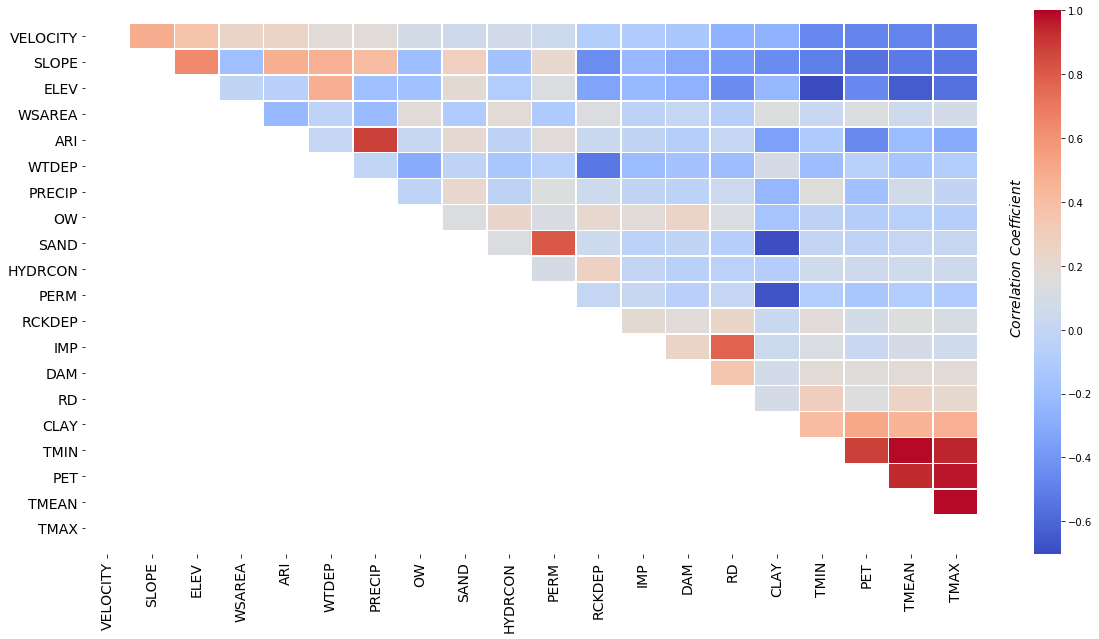

In [14]:
# Actually only for feature engineering - ie, use all variables
# But no problem if even used for sparse model
# a = data.corr()
a = train_data.corr()

# a = df[selected].corr()
# a[a==1] = 0
a.style.background_gradient(cmap='YlGn').set_precision(2)

# data.corr().style.background_gradient(cmap='YlGn').set_precision(2)
import seaborn as sns

plt.figure(figsize=(20, 10))
# plt.figure(figsize=(10, 7))
mask = np.zeros_like(a)
mask[np.tril_indices_from(mask)] = True #populate lower triangular matrix with ones
# with sns.axes_style("white"):
#     ax = sns.heatmap(a, mask=mask, vmax=.3, square=True)
# cm = sns.palplot(sns.color_palette("Greens"))
ax = sns.heatmap(a, mask=mask, annot=False, cmap='coolwarm', fmt='.1f', linewidths=0.5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# sns.heatmap(a, mask=mask, annot=False, cmap='coolwarm')
# plt.title('Correlation Matrix')
ax.tick_params(axis='both', labelsize=14)
ax.tick_params(axis='x', labelrotation=90)
ax.text(20.7, 12, '$Correlation\ Coefficient$', rotation='vertical', color='k', fontsize=14)
plt.savefig(fig_folder + '/{}'.format('corr_matrix'), transparent=True, pad_inches=0, facecolor=None);
# plt.savefig(fig_folder + '/{}'.format('corr_matrix'), transparent=True, pad_inches=0);

# To plot map of mopex gages using geopandas

Total gages in ref_gages.shp : 1224
1073


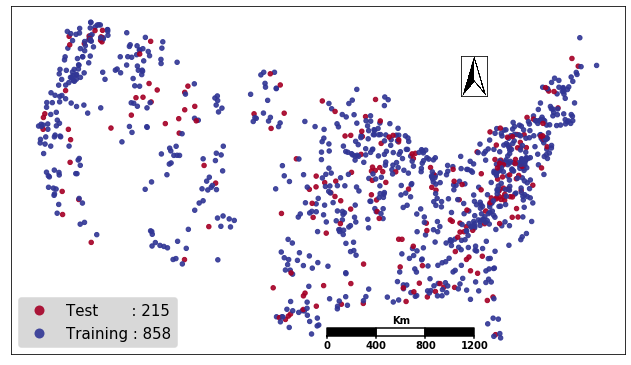

In [15]:

gdf = gpd.read_file('data/ref_gages.shp')
gdf.index = gdf.site_no
print(f"Total gages in ref_gages.shp : {len(gdf)}")

# Get the subset of gdf gages (based on list of df because we have same indices in both)
gdf = gdf.loc[list(df.index)]
print(len(gdf))

# Add a new columns called lbl (label) , 
gdf['lbl'] = 'Training : {}'.format(len(X_train))
for idx in y_test.index:
    gdf.loc[idx, 'lbl'] = 'Test       : {}'.format(len(X_test))
    

fig, ax = plt.subplots(1, 1, figsize=(11, 7))

# Uncomment these 3 lines if you have the conus map (the outline of usa boundary)
# conus = gpd.read_file('/home/yadav.111/Github/giuh/inputs/ancillary_maps/conus_dissolve.shp')
# conus = conus.to_crs(gdf.crs)
# conus.plot(color='white', edgecolor='gray', lw=2, ax = ax)
gdf.plot(column = 'lbl', marker='o', categorical=True, legend=True, ax=ax, alpha=.9, markersize=20, cmap=plt.cm.RdYlBu,
         legend_kwds={'frameon': True, 'loc':3, 'fontsize':15, 'facecolor':'gray', 'framealpha':.3})
ax.set_xticks([])
ax.set_yticks([]);
add_osgb_scalebar(ax, at_x=(0.56, 0.7), at_y=(0.05, 0.075), max_stripes=3)

north_arrow = mpimg.imread('north.png')
ax1 = plt.axes([.67, .67, .08, .08])
plt.imshow(north_arrow)
plt.xticks([])
plt.yticks([])

plt.savefig(fig_folder + '/velocity_gages', transparent=True, pad_inches=0);

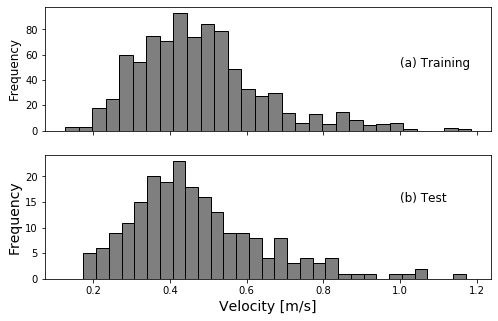

In [16]:
# Check the distribution of "y" training and test set: they should match
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True, sharey=False)

y_train.plot(kind='hist', density=False, label='train', bins=30,color='C7', edgecolor='k', ax=ax[0])
y_test.plot(kind='hist', density=False, label='test', bins=30, color='C7', edgecolor='k', ax=ax[1])
plt.xlabel('Velocity [m/s]')
# plt.legend(frameon=True);
ax[0].set_xlabel('')
ax[0].set_ylabel('Frequency', fontsize=12)
# ax[0].legend(frameon=True)
ax[0].text(1, 50, '(a) Training', fontsize=12)

ax[1].set_xlabel('Velocity [m/s]', fontsize=14)
# ax[1].legend(frameon=True)
ax[1].set_ylabel('Frequency', fontsize=14)
ax[1].text(1, 15, '(b) Test', fontsize=12)

plt.savefig(fig_folder + '/{}'.format('vel_hist'), transparent=True, pad_inches=0)

# Cross-Validation with grid search to optimize on multiple parameters
Training-Validation-Testing

In [17]:
# Write a function for k-fold cross validation
def k_fold_val(grid, txt_lbl=None):
    grid.fit(X_train, y_train)
    # Fitted result dictionary. Save everything needed later here
    res = {}
    model_name = grid.estimator.__repr__().split('(')[0] #Python3
    try:
        # Remove the Regressor suffix if it exist [mostly of RF, ET, etc]
        model_name = model_name.split('Regressor')[0] #Regressor Regression
    except:
        pass
    
    res['best_params'] = grid.best_params_
    res['best_estimator'] = grid.best_estimator_
    res['grid'] = grid #maybe we need the whole grid meta-estimator
    # Accurracy/error metrics
    res['val_score'] = grid.best_score_
    res['train_score'] = grid.score(X_train, y_train)
    res['test_score'] = grid.score(X_test, y_test)

    test_pred = grid.predict(X_test)
    res['explained_variance'] = metrics.explained_variance_score(y_test, test_pred)
    res['MAE'] = metrics.mean_absolute_error(y_test, test_pred)
    res['MSE'] = metrics.mean_squared_error(y_test, test_pred)
    res['median_absolute_error'] = metrics.median_absolute_error(y_test, test_pred)
    
    train_pred = grid.predict(X_train)
    res['explained_variance_tr'] = metrics.explained_variance_score(y_train, train_pred)
    res['MAE_tr'] = metrics.mean_absolute_error(y_train, train_pred)
    res['MSE_tr'] = metrics.mean_squared_error(y_train, train_pred)
    res['MedAE_tr'] = metrics.median_absolute_error(y_train, train_pred)

    
    # Save results in a dict (defined outside, in global scope)
    all_models[model_name] =res

    print(f"{model_name}, Fitted Params = {grid.best_params_}")
    print(f"Scores: Cross_val = {res['val_score']:.2f}, Train = {res['train_score']:.2f}, Test = {res['test_score']:.2f}\n")
    plt.figure(figsize=(2.0, 2.0))
    plt.plot(y_train, grid.predict(X_train), 'o', alpha=0.6, label='train', markersize=3)
    plt.plot(y_test, grid.predict(X_test), 'ro', alpha=0.7, label='test', markersize=3)
    
    if txt_lbl:
        plt.text(.15, 1.25, '({})'.format(txt_lbl), fontsize=10)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(.15, 1.0, '$R^2$ = {:.2f}'.format(res['test_score']), bbox=props, fontsize=9)
    plt.plot([0, 1.3], [0, 1.4], '--', lw=1, c='gray')
    plt.axis([0, 1.3, 0, 1.4])

    plt.title(f"{model_name}", fontsize=10)
    plt.xticks([.0, .6, 1.2], fontsize=9)
    plt.yticks([.0, .6, 1.2], fontsize=9)

    plt.xlabel('Measured Velocity [m/s]', fontsize=9)
    plt.ylabel('Predicted Velocity [m/s]', fontsize=9);
    plt.savefig(f'{fig_folder}/{model_name}', transparent=True, bbox_inches='tight')
    

    #DIRECTLY MERGE ABOVE IF LEARNING CURVE REQUIRED
    # Given the estimator, plot the learning curve (for overfitting/underfitting visualization)
    #train_sizes=[.4, .5, .6, .7, .8, .9, 1.]
    train_sizes, train_scores, test_scores = learning_curve(grid.best_estimator_, X, y, cv=cv,
                                                               scoring="r2", n_jobs=-1,
                                                               train_sizes = np.linspace(.1, 1.0, 25)) #20
    # Plot Learning Curve
    plt.figure(figsize=(2.0, 2.0))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean , color="C0", label="Training") #, label="Training"
    plt.plot(train_sizes, test_scores_mean, color="r", label="Cross-validation") #, label="Cross-validation"
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.25, color="C0")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.25, color="r")
    
    #plt.title('Learning Curves ({})'.format(model_name))
    plt.title(f"{model_name}", fontsize=10)
    plt.xlabel('Training sample size', fontsize=9)
    plt.ylabel('$R^2$', fontsize=9)
    plt.ylim([0, 1])
    plt.legend(loc='best', fontsize=7)
    plt.savefig(f'{fig_folder}/{model_name}_learn', transparent=True, bbox_inches='tight')    

In [18]:
# Save the results of grid search in a dictionary
all_models = {}

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   22.6s finished


RandomForest, Fitted Params = {'n_estimators': 275}
Scores: Cross_val = 0.55, Train = 0.94, Test = 0.65

Elapsed time is 1.36 minutes.


'Elapsed time is 1.36 minutes.'

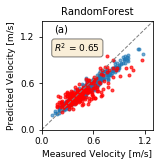

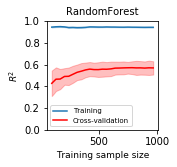

In [19]:
tic()
# Random Forest Regressor
param_grid = {'n_estimators': np.arange(25, 301, 25)}
grid = GridSearchCV(ensemble.RandomForestRegressor(oob_score=True, random_state=randomseed), 
                    param_grid=param_grid, cv=cv, verbose=1, n_jobs=-1)
k_fold_val(grid, txt_lbl='a')
# Save Feature Importance for RF in a DataFrame
feat_df = pd.DataFrame(pd.Series(grid.best_estimator_.feature_importances_, index = X.columns),columns = ['RandomForest'])
toc()

In [20]:
metrics_df = pd.DataFrame(grid.cv_results_)
metrics_df.index = metrics_df.param_n_estimators

In [21]:
metrics_df.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
param_n_estimators,,,,,,,,,,,,,,,,,,,
25,0.302017,0.007831,0.003124,0.006248,25,{'n_estimators': 25},0.602381,0.581079,0.563036,0.530466,0.455592,0.479647,0.439652,0.628681,0.548278,0.520469,0.534928,0.059241,12
50,0.571080,0.015514,0.006182,0.006799,50,{'n_estimators': 50},0.611118,0.575298,0.564389,0.571570,0.475548,0.493430,0.421851,0.622754,0.577301,0.519592,0.543285,0.060602,11


ExtraTrees, Fitted Params = {'n_estimators': 300}
Scores: Cross_val = 0.58, Train = 0.98, Test = 0.66

Elapsed time is 34.508 seconds.


'Elapsed time is 34.508 seconds.'

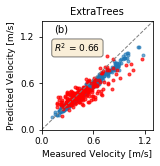

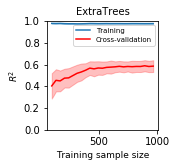

In [22]:
tic()
# Extra-Trees
param_grid = {'n_estimators': np.arange(25, 301, 25)}
grid = GridSearchCV(ensemble.ExtraTreesRegressor(min_samples_leaf = 2), param_grid=param_grid, cv=cv, n_jobs=-1)
k_fold_val(grid, txt_lbl='b') #txt_lbl = b or e
feat_df['ExtraTrees'] = pd.Series(grid.best_estimator_.feature_importances_, index = X.columns)
toc()

In [23]:
# Sanity Check on where we are
if full_feature_flag:
    print('yes Full feature', full_feature_flag)
else:
    print('Sparse Features', full_feature_flag)

yes Full feature 1


Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1274 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 1824 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 37.1min finished


GradientBoosting, Fitted Params = {'n_estimators': 4975}
Scores: Cross_val = 0.54, Train = 0.75, Test = 0.65

Elapsed time is 43.87 minutes.


'Elapsed time is 43.87 minutes.'

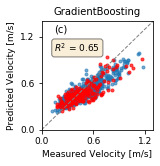

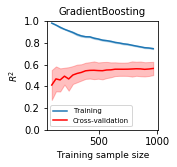

In [24]:
tic()
# GradientBoostingRegressor : This takes a longer time 15 mins to 2 hours depeding on processor
param_grid = {'n_estimators': np.arange(0, 5001, 25)[1:]} #250
grid = GridSearchCV(ensemble.GradientBoostingRegressor(learning_rate=0.001, max_depth=3), param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1)
k_fold_val(grid, txt_lbl='c') #c f
feat_df['GradientBoosting'] = pd.Series(grid.best_estimator_.feature_importances_, index = X.columns)
toc()

## Feature Importance Plot

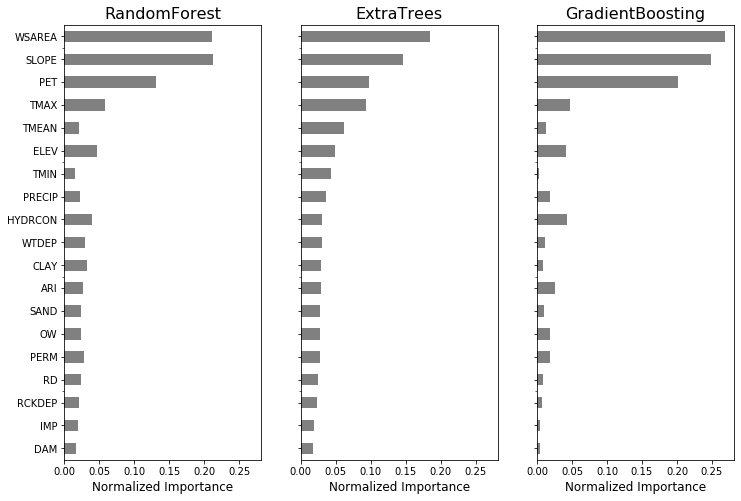

In [25]:
axarr = feat_df.sort_values(by='ExtraTrees').plot(kind='barh', subplots=True, layout=(1, -1), 
                                                  legend=False, sharey=True, color=['gray'], figsize=(12, 8));

for ax in axarr.flat:
    ax.set_xlabel('Normalized Importance', fontsize=12)
    ax.title.set_size(16)
plt.savefig(fig_folder + '/feat_imp', transparent=True, pad_inches=0)

In [26]:
# all_models.keys()
print("Random seed : {}".format(randomseed))
print("Estimator\t\t       Cross_val  Train   Test")
print("-------------------------------------------------------")
for models in all_models:
    print("{:<25}    :\t  {:.2f} \t  {:.2f}    {:.3f}".format(models, all_models[models]['val_score'], 
                                                  all_models[models]['train_score'], all_models[models]['test_score']))

Random seed : 28
Estimator		       Cross_val  Train   Test
-------------------------------------------------------
RandomForest                 :	  0.55 	  0.94    0.649
ExtraTrees                   :	  0.58 	  0.98    0.657
GradientBoosting             :	  0.54 	  0.75    0.650


In [27]:
print("Estimator : \t\t  MAE   MAE_tr    MSE   MSE_tr")
for models in all_models:
    print(f"{models:<25} {all_models[models]['MAE']:.2f}  {all_models[models]['MAE_tr']:.2f}\t{all_models[models]['MSE']:.3f}  {all_models[models]['MSE_tr']:.3f}")

Estimator : 		  MAE   MAE_tr    MSE   MSE_tr
RandomForest              0.08  0.03	0.011  0.002
ExtraTrees                0.08  0.02	0.011  0.001
GradientBoosting          0.08  0.06	0.011  0.007


# Save these results

In [28]:

if full_feature_flag:
    pkl_file = f'{results_folder}/models_all_feat{randomseed}.pkl' # for all 19 variables
else:
    pkl_file = f'{results_folder}/models{randomseed}.pkl' # for subset of features

---
END
---